# QUBOLS Solver Performance Analysis

We test here the QUBOLS SOLVER in isolation to explore its performance.

Wr first define the system we want to explore

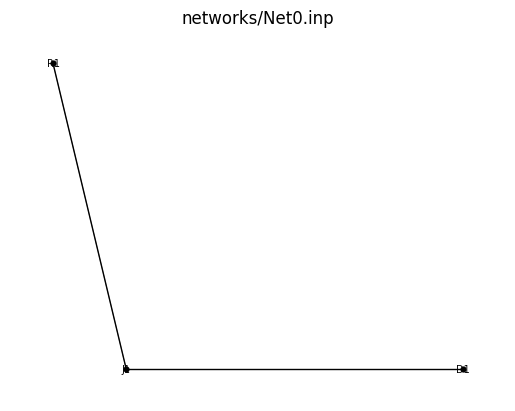

<Axes: title={'center': 'networks/Net0.inp'}>

In [1]:
import wntr
import wntr_quantum

# Create a water network model
inp_file = 'networks/Net0.inp'
# inp_file = 'networks/Net2Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

We then solve it with the internal Cholesky solver implemented in WNTR Quantum

/home/nico/QuantumApplicationLab/vitens/wntr-quantum/wntr_quantum/epanet/Linux/libepanet22_amd64.so
Solving the linear system Ax = b with:
A =  [[ 0.116 -0.116]
 [-0.116  2.454]]
b =  [ -1.614 230.277]
x =  [83.8   97.772]
residue =  3.218344867404965e-14
Solving the linear system Ax = b with:
A =  [[ 0.027 -0.027]
 [-0.027  0.84 ]]
b =  [-0.934 79.982]
x =  [62.886 97.269]
residue =  8.43769498715119e-15
Solving the linear system Ax = b with:
A =  [[ 0.027 -0.027]
 [-0.027  0.84 ]]
b =  [-0.934 79.985]
x =  [62.886 97.269]
residue =  2.0317081350640365e-14


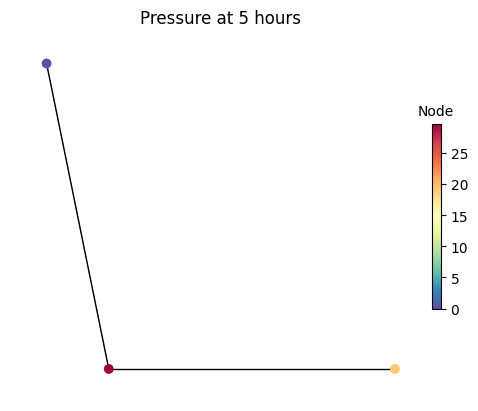

<Axes: title={'center': 'Pressure at 5 hours'}>

In [2]:
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)
results = sim.run_sim()

# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

The last matrix of the Newton Raphson has been stored in the `tmp` directory of EPANET. We can load it to further analyze how VQLS performs on it.

In [3]:
import sys
import os 
epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]
util_path = os.path.join(epanet_path, 'src/py/')
sys.path.append(util_path)

from quantum_linsolve import load_json_data 
A, b = load_json_data(os.path.join(epanet_tmp,'smat.json'))

In [4]:
from quantum_newton_raphson.qubo_solver import QUBO_SOLVER
qubols = QUBO_SOLVER(
    num_qbits=13,
    num_reads=500,
    # iterations=5,
    range=250,
    offset=0,
    # temperature=1e4,
    use_aequbols=False,
)

We can solve the system using VQLS

In [5]:
res = qubols(A.todense(), b)

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


And plot the vqls solution compared to the LU solution

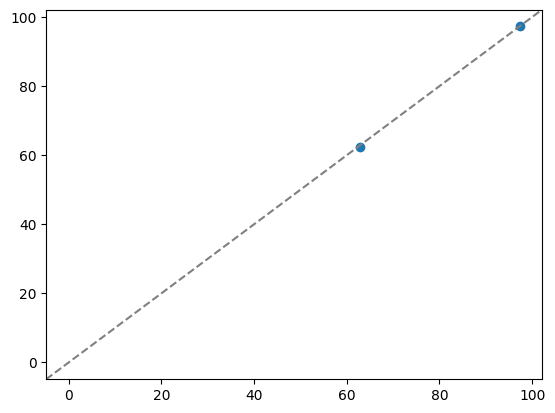

In [7]:
import numpy as np 
import matplotlib.pyplot as plt
ref = np.linalg.solve(A.todense(),b)

plt.scatter(ref, res.solution)
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.show()